In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import signac
import cg_pyrosetta
import numpy as np
import pandas as pd
import copy
import os
import flow
import analyze_foldamers
import matplotlib.pyplot as plt
from matplotlib import cm
import mdtraj as md
from flow import FlowProject
plt.rcParams["font.family"] = "serif"
plt.rcParams.update({"font.size" : 15})

# Jupyter Notebook for developing analysis for CG PyRosetta simulations

# These analyses should be saved and eventually moved into their own dedicated functions
# Also all figures should be saved as their own PDFs for use in papers

## Load in Signac project
Here we're using the signac python API to pull in the project in this working directory. Using the `signac.detec_schema()` command we are able to pull all the state points of each simulation we ran.

In [9]:
for item in schema.items():
    print(item[1].values())

dict_values([{0.5, 1.2777777777777777, 2.4444444444444446, 3.2222222222222223, 4.0, 1.6666666666666667, 2.8333333333333335, 0.8888888888888888, 2.0555555555555554, 3.611111111111111}])
dict_values([{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}])


In [8]:
project = signac.get_project()
schema = project.detect_schema()
sc_sizes, reps = schema.items()
sc_sizes = list(sc_sizes[1][float])
sc_sizes.sort()

In [10]:
# Show all SC sizes we ran
sc_sizes

[0.5,
 0.8888888888888888,
 1.2777777777777777,
 1.6666666666666667,
 2.0555555555555554,
 2.4444444444444446,
 2.8333333333333335,
 3.2222222222222223,
 3.611111111111111,
 4.0]

We can now iterate over all simulations and sort them based on which state point variable they were simualating. We now have a list of all directories in the `workspace` that correspond to each type of SC size. 

In [11]:
for sc_size in sc_sizes:
    print("SC Size = " + str(round(sc_size, 4)))
    for job in project.find_jobs({'sc_size':sc_size}):
        print(job.id)

SC Size = 0.5
be3e60c5f7bc937904c97347db675c8f
21751d80204d43046ec9173557795a83
09eca16ec26de9ac06ba1eb279b5cd74
fbc6c8b7530a44f4892b977fc884dfd8
e15d29641943b461cfdd5772b10ce3af
01f2ed2bae3aaab3004b6e378e367016
abf72ee214e11a1bfc233ba4029bbce9
22cda661f4a0c5388be9f7e872891363
556cbee4e4c22f741c817230d77b85b5
be98e2ccf70251de10cec99b566a88ce
77afe67389416aa2347c1363a3dba33e
16d6b2eaf0b7660ce307999db7803c07
e43dca448d082dd6c5c13a3f9d4185f0
92bc2d34eaa96b4670e9da3231a6cac9
5389d83f0b09f2725d369d4815584306
e6af1fb43306b0b9039da1cbe24562ad
d55c106905b405fde13148ed267ad136
2e26309715150ba8997caca8c79bcaf4
279b5de8de941b137ff5909da18d5848
c1759ce7ca5ffc70a4b4f9ed2a07b704
096dbd98a799e5fccf1b86a7b156765b
6ebbbbf9ff901565b6063308bdf9e9c9
14626f6f2c29090c0e88ef7ffe4645a3
14508b00a45b351cac40c54ccaea7fdc
38e247fb868643138e1ddfa860b78f11
8c18cc2bce9cc50b992fa60dac393f03
dbc995ac7226a94e805133d87ad86737
a5e848f16f251463e661b1de3a411377
c6a9dde277b0d78e01392309daab5a48
01a33184356aca40482e6f4ca8238

In [12]:
kts = np.array([10 * ( 0.9 ) ** i for i in range(50)])
out_steps = np.array([10000 * i for i in range(50)])
print(kts)

[10.          9.          8.1         7.29        6.561       5.9049
  5.31441     4.782969    4.3046721   3.87420489  3.4867844   3.13810596
  2.82429536  2.54186583  2.28767925  2.05891132  1.85302019  1.66771817
  1.50094635  1.35085172  1.21576655  1.09418989  0.9847709   0.88629381
  0.79766443  0.71789799  0.64610819  0.58149737  0.52334763  0.47101287
  0.42391158  0.38152042  0.34336838  0.30903154  0.27812839  0.25031555
  0.225284    0.2027556   0.18248004  0.16423203  0.14780883  0.13302795
  0.11972515  0.10775264  0.09697737  0.08727964  0.07855167  0.0706965
  0.06362685  0.05726417]


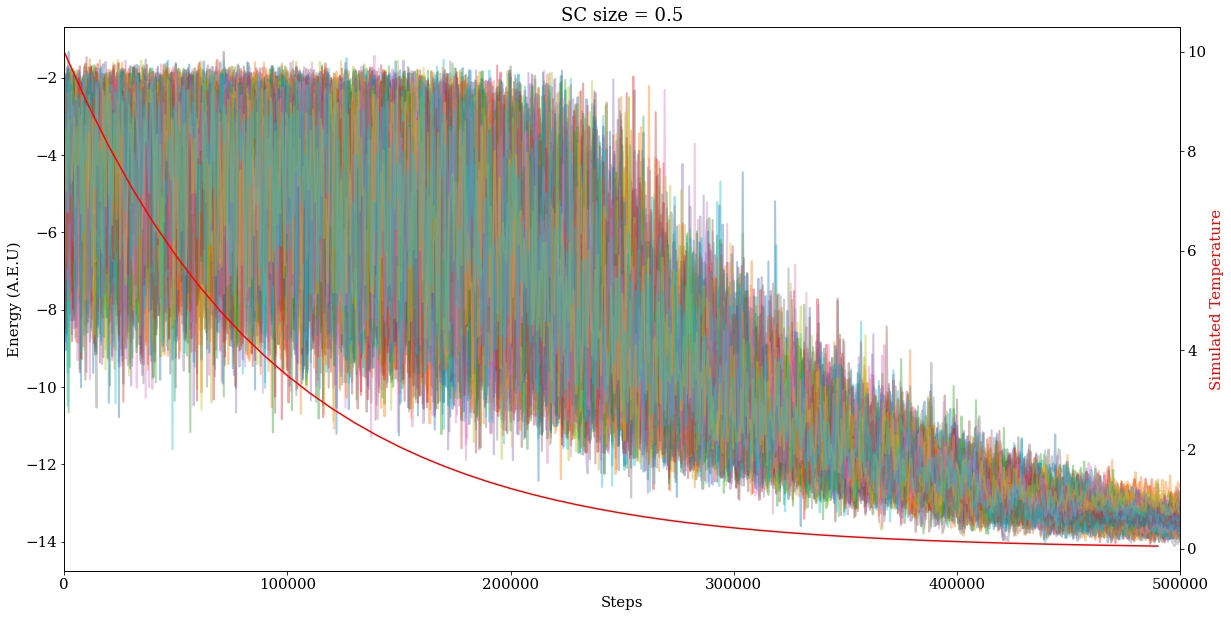

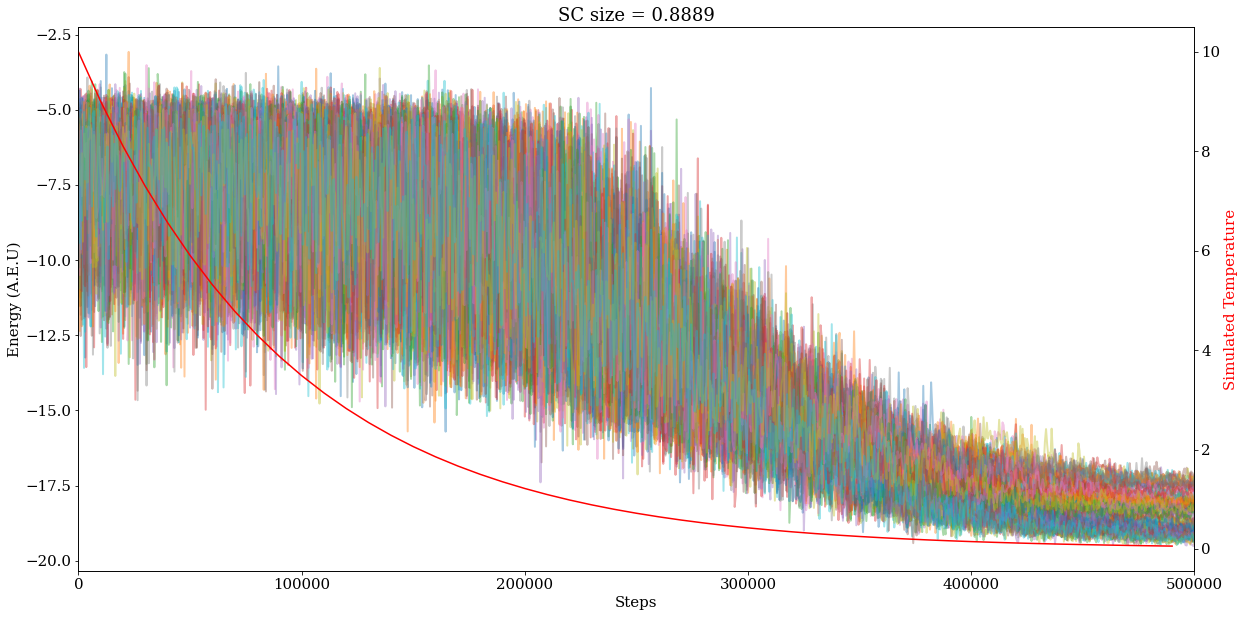

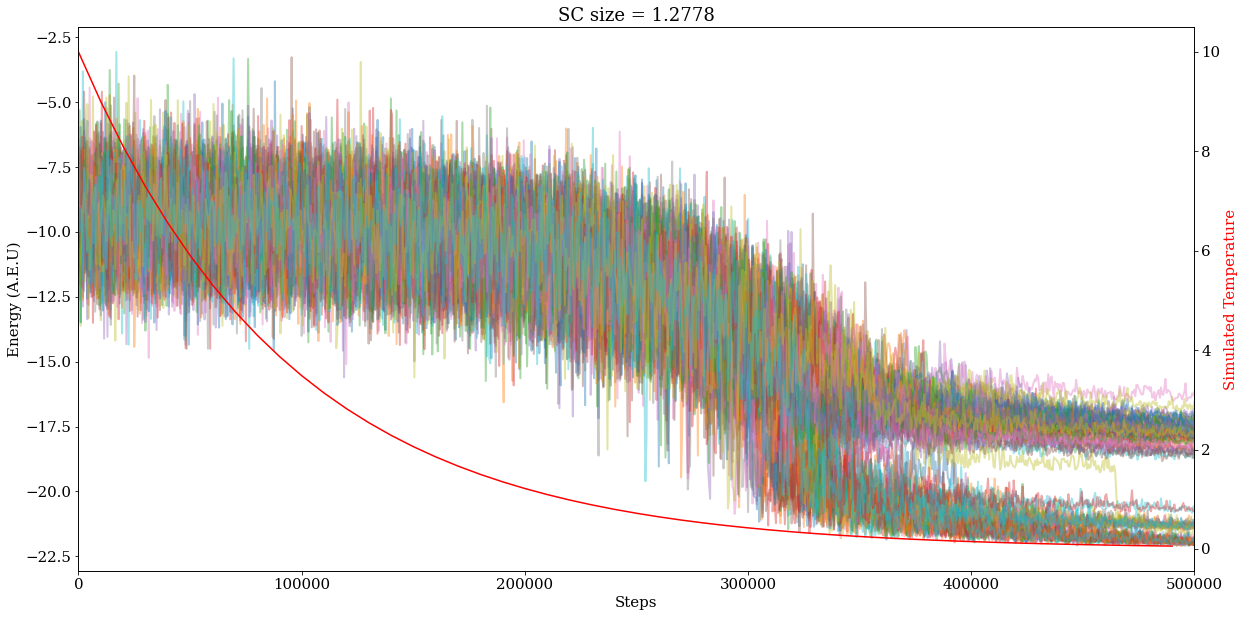

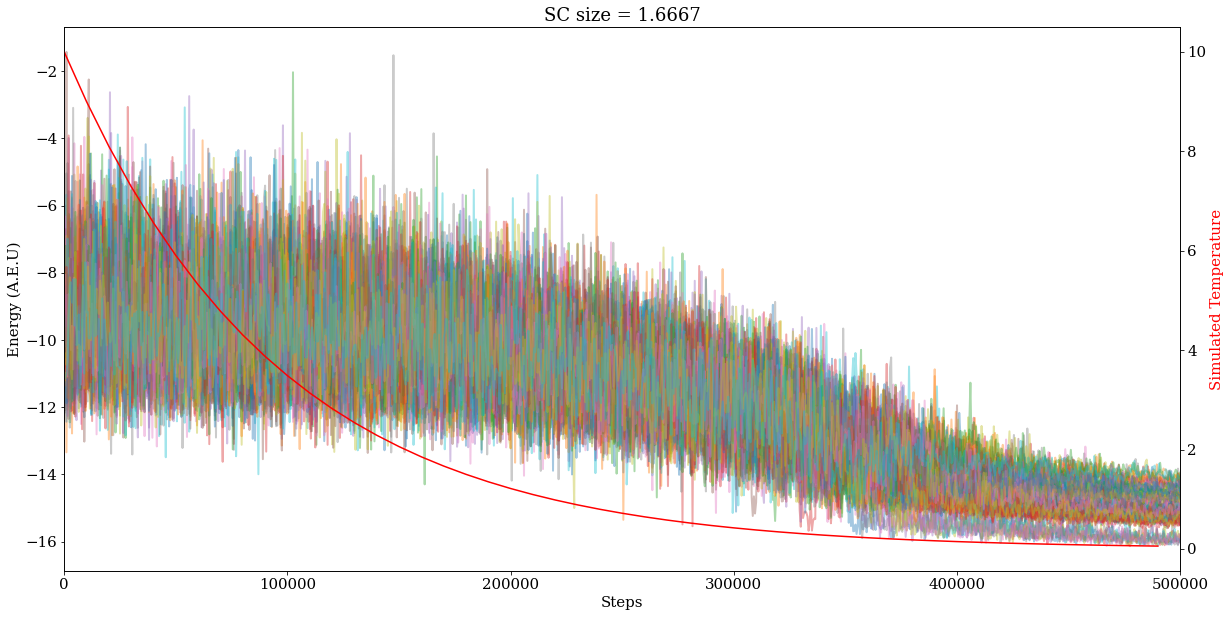

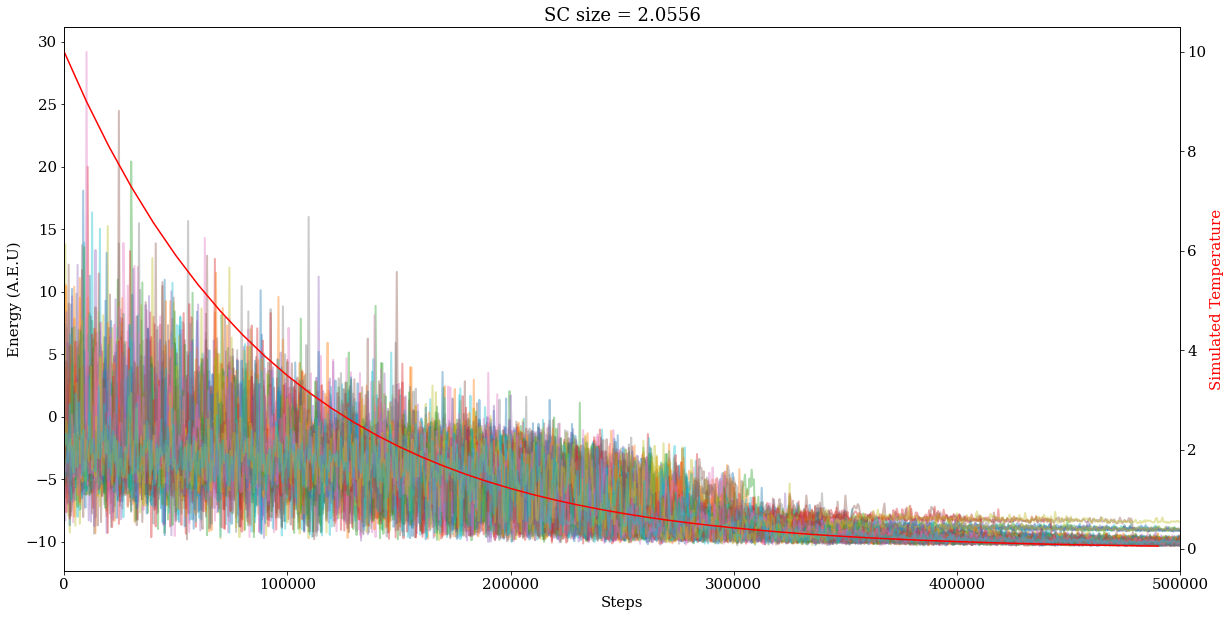

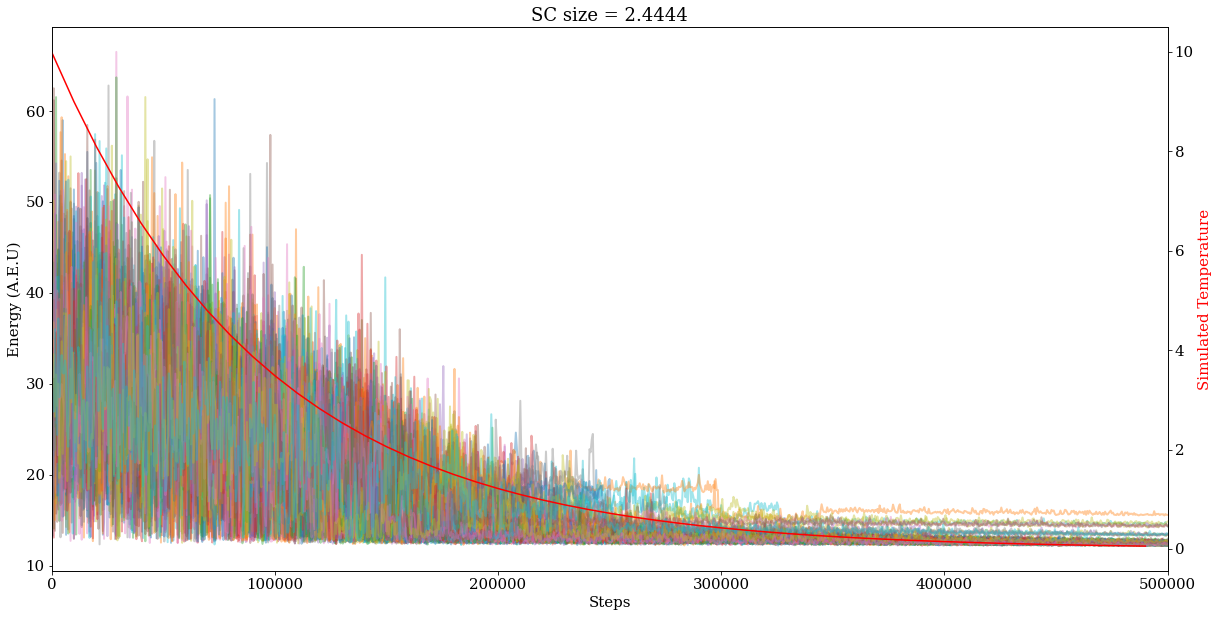

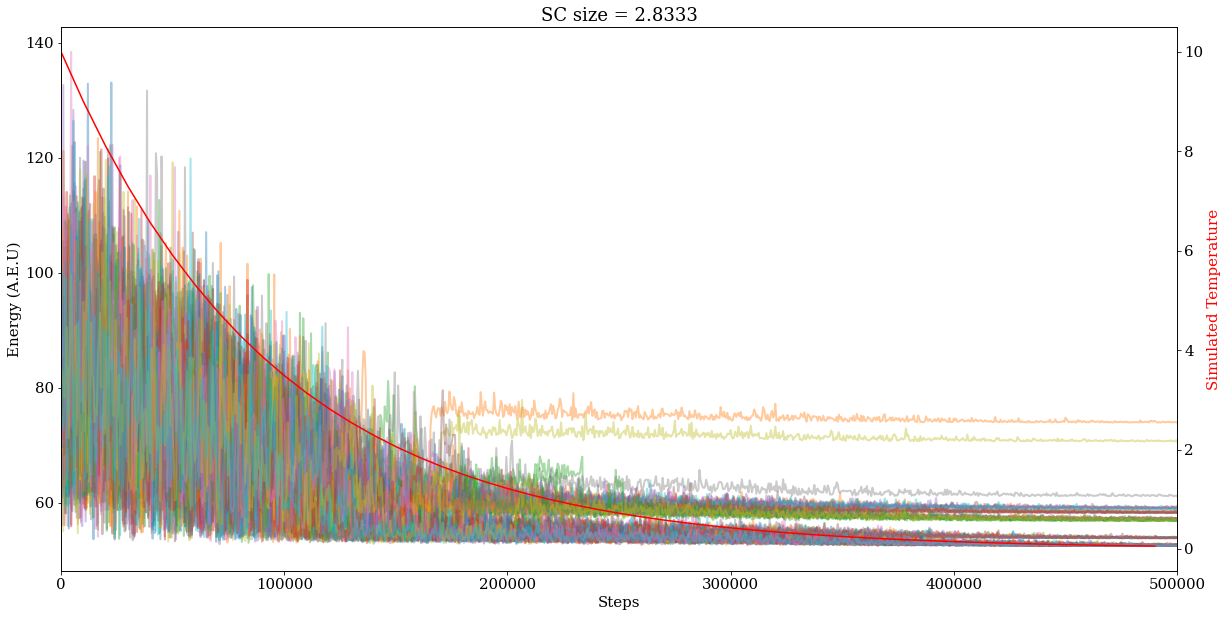

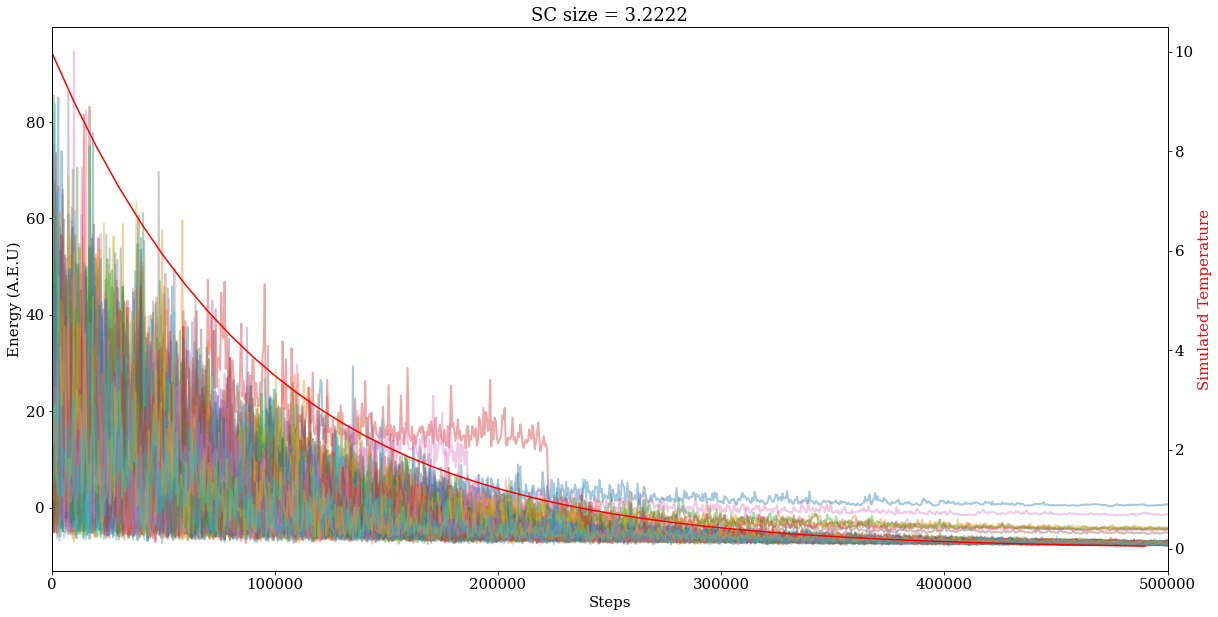

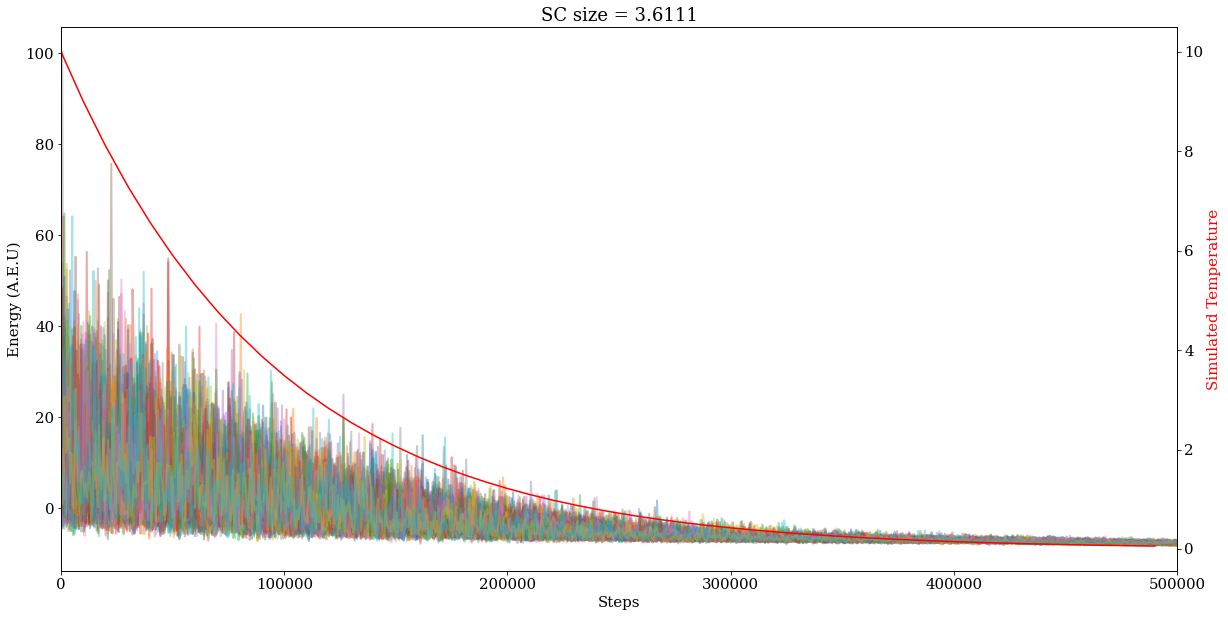

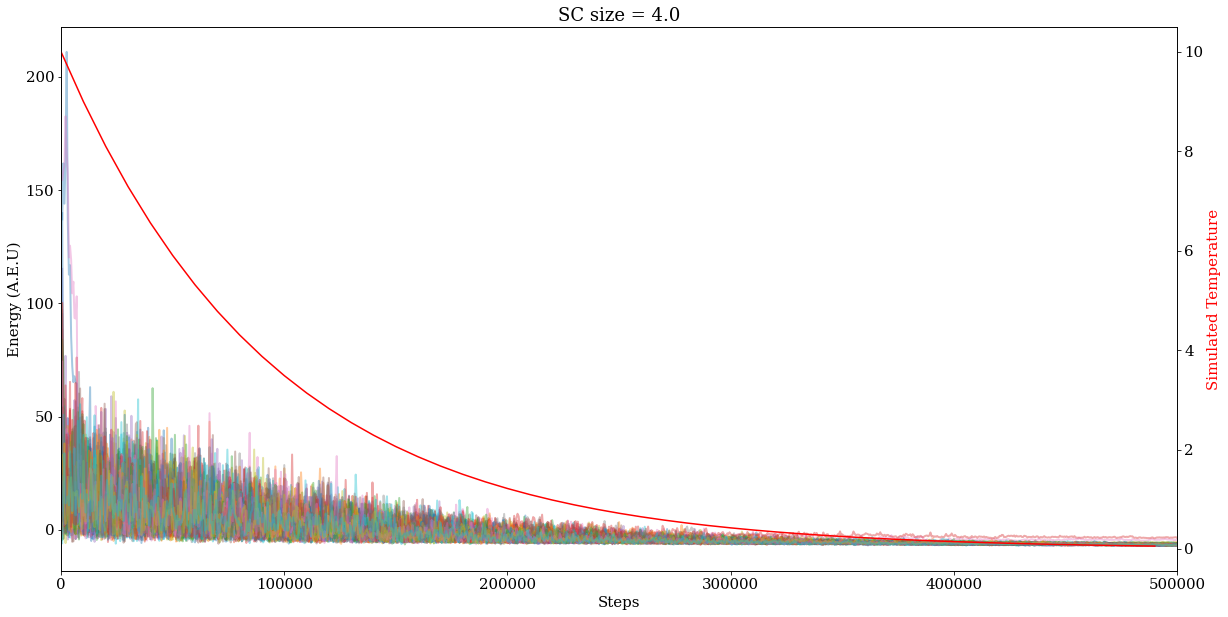

In [13]:
for sc_size in sc_sizes:
    fig, ax1 = plt.subplots(1,1,figsize = [20,10])
    ax2 = ax1.twinx()
    ax2.plot(out_steps, kts, 'r')
    ax2.set_xlim([0, 500000])
    ax2.set_ylabel("Simulated Temperature", color = 'r')
    for job in project.find_jobs({'sc_size':sc_size}):
        energy_file = job.fn("energies.txt")
        if os.path.isfile(energy_file):
            energies = pd.read_csv(energy_file, header=None)
            ax1.plot(energies.values[:,0], energies.values[:,1], alpha = 0.4, lw=2)
            ax1.set_xlabel("Steps")
            ax1.set_ylabel("Energy (A.E.U)")
            # ax1.set_xlim([0, 500000])
            ax1.set_title("SC size = " + str(round(job.sp['sc_size'],4)))
        else:
            print("sc_size", sc_size, "hasn't started yet")    


In [14]:
sc_sizes

[0.5,
 0.8888888888888888,
 1.2777777777777777,
 1.6666666666666667,
 2.0555555555555554,
 2.4444444444444446,
 2.8333333333333335,
 3.2222222222222223,
 3.611111111111111,
 4.0]

In [37]:
# DBSCAN Clustering
test = [sc_sizes[2]] #temporary
for sc_size in test:
    traj_file_list = []
    all_energies = []
    energy_traj = []
    for job in project.find_jobs({'sc_size':sc_size}):
        structure_file = job.fn('trajectory.pdb')
        traj_file_list.append(structure_file)
        energy_file = job.fn('energies.txt')
        energies = pd.read_csv(energy_file, header = None)
        energy_traj.append(energies.values[:, 1])
        all_energies.extend(energies.values[:, 1])
    all_energies = np.array(all_energies)

filtered 50.00333333333333 % of data using:
cutoff radius = 0.007092969224456241
number neighbors cutoff: 7.770806311629713


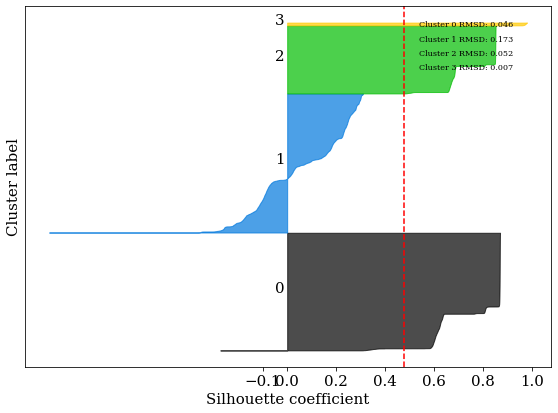

In [38]:
medoid_positions, cluster_sizes, cluster_rmsd, n_noise, silhouette_avg, labels, original_indices = analyze_foldamers.cluster.\
get_cluster_medoid_positions_DBSCAN(traj_file_list, eps = 0.15, min_samples = 30, frame_start = 700, frame_stride = 1, output_dir="cluster_output", cgmodel=None, plot_silhouette=True, filter=True, filter_ratio = 0.5, output_cluster_traj = True)

In [39]:
len(original_indices)

14999

In [40]:
len(labels)

14999

In [41]:
cluster_sizes

[5387, 6358, 3106, 128]

5387
5387
6358
6358
3106
3106
128
128


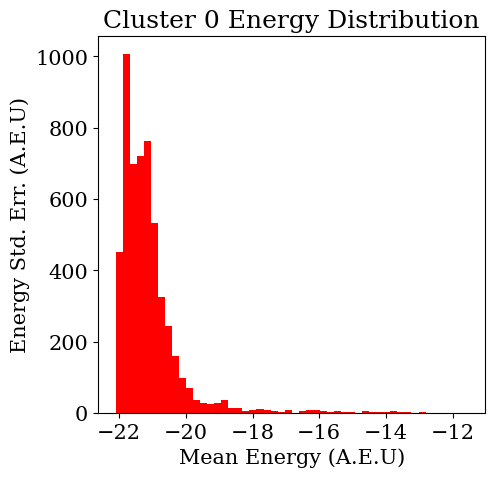

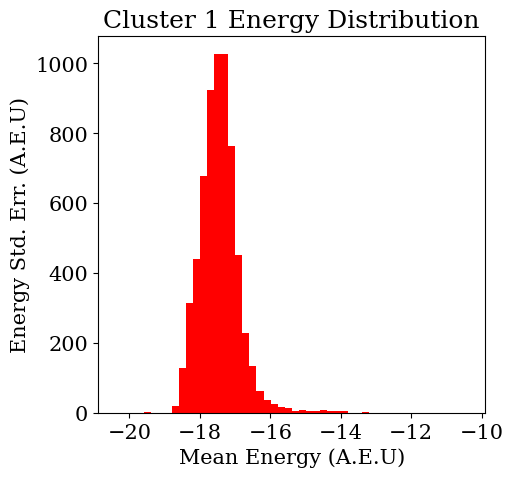

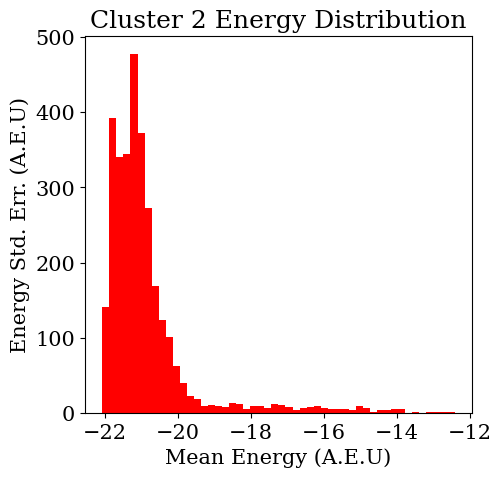

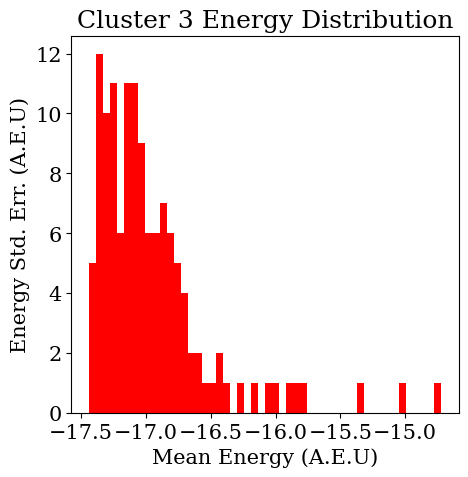

In [42]:
clusters = np.unique(labels)
for i in clusters[1:]:
    plt.figure(figsize = [5, 5], dpi=100)
    cluster_indices = np.where(labels == i)[0]
    cluster_energies = all_energies[original_indices[cluster_indices]]
    print(len(cluster_energies))
    print(cluster_sizes[i])
    mean_energy = np.mean(cluster_energies)
    std_energy = np.std(cluster_energies)
    color = cm.nipy_spectral(float(i) / len(clusters[1:]))
    plt.hist(cluster_energies, bins = 50, color='red')
    plt.xlabel("Mean Energy (A.E.U)")
    plt.ylabel("Energy Std. Err. (A.E.U)")
    plt.title("Cluster " + str(i)+ " Energy Distribution")

In [43]:
std_energy

0.4526101115870144

In [44]:
len(all_energies)

100000

In [45]:
clusters[1], clusters[2] = clusters[2], clusters[1]
clusters

array([-1,  1,  0,  2,  3])

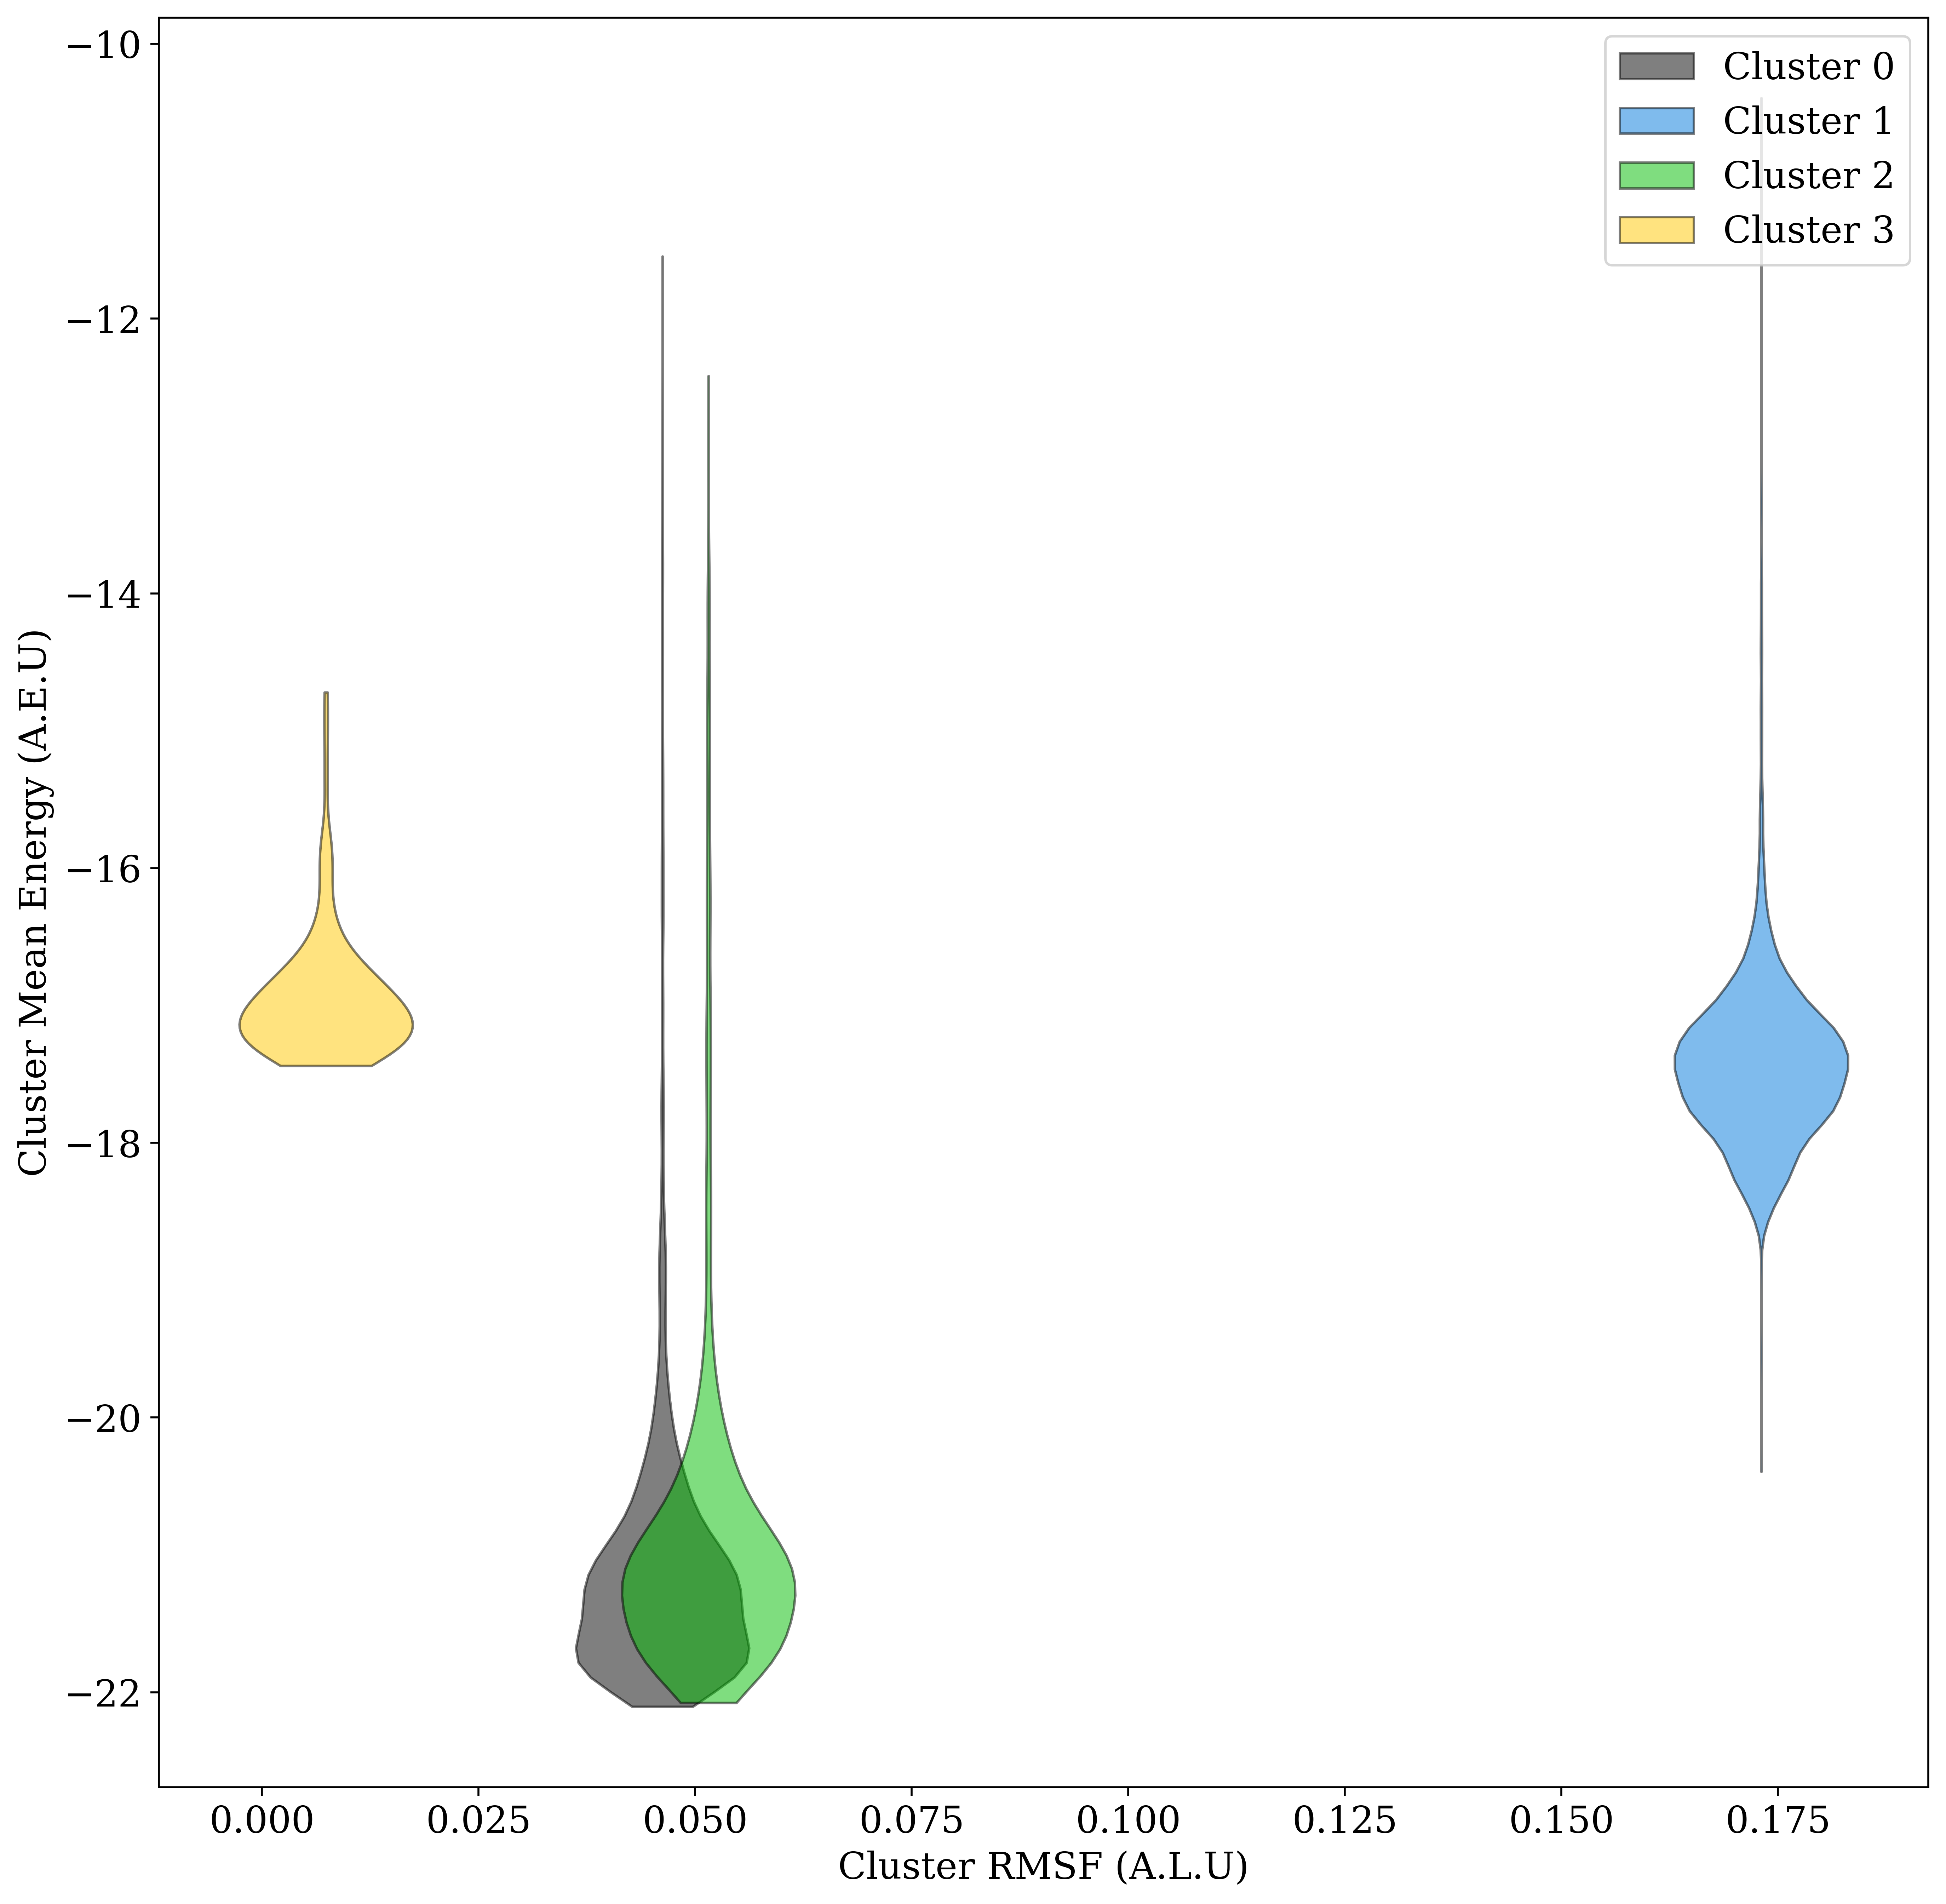

In [46]:
fig = plt.figure(figsize = [10, 10], dpi=500)
ax = fig.add_axes([0,0,1,1])
clusters = np.unique(labels)
energy_dists = []
for i in clusters[1:]:
    cluster_indices = np.where(labels == i)[0]
    cluster_energies = all_energies[original_indices[cluster_indices]]
    energy_dists.append(cluster_energies)

# 
# plt.errorbar(cluster_rmsd[i], avg_energy, c = color, yerr=std_energy, fmt='o', markersize=10, capsize=5)
parts = ax.violinplot(energy_dists, positions = cluster_rmsd, showextrema=False, showmeans=False, widths = 0.02)
for i, pc in enumerate(parts['bodies']):
    color = cm.nipy_spectral(float(i) / len(clusters[1:]))
    pc.set_facecolor(color)
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)
# quartile1, medians, quartile3 = np.percentile(energy_dists, [25, 50, 75])
# plt.scatter(medians, marker = 'o')
plt.xlabel("Cluster RMSF (A.L.U)")
plt.ylabel("Cluster Mean Energy (A.E.U)")
plt.legend(["Cluster "+ str(a) for a in clusters[1:]], loc = "best")

In [47]:
# Get all simulation trajectories in a list of trajectories/in a single trajectory
sim_traj = []
all_traj = None
for job in project.find_jobs({'sc_size':sc_sizes[2]}):
    job_traj = md.load(job.fn("trajectory.pdb"))
    sim_traj.append(job_traj)
    if all_traj is None:
        all_traj = job_traj
    else:
        all_traj = all_traj.join(job_traj)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

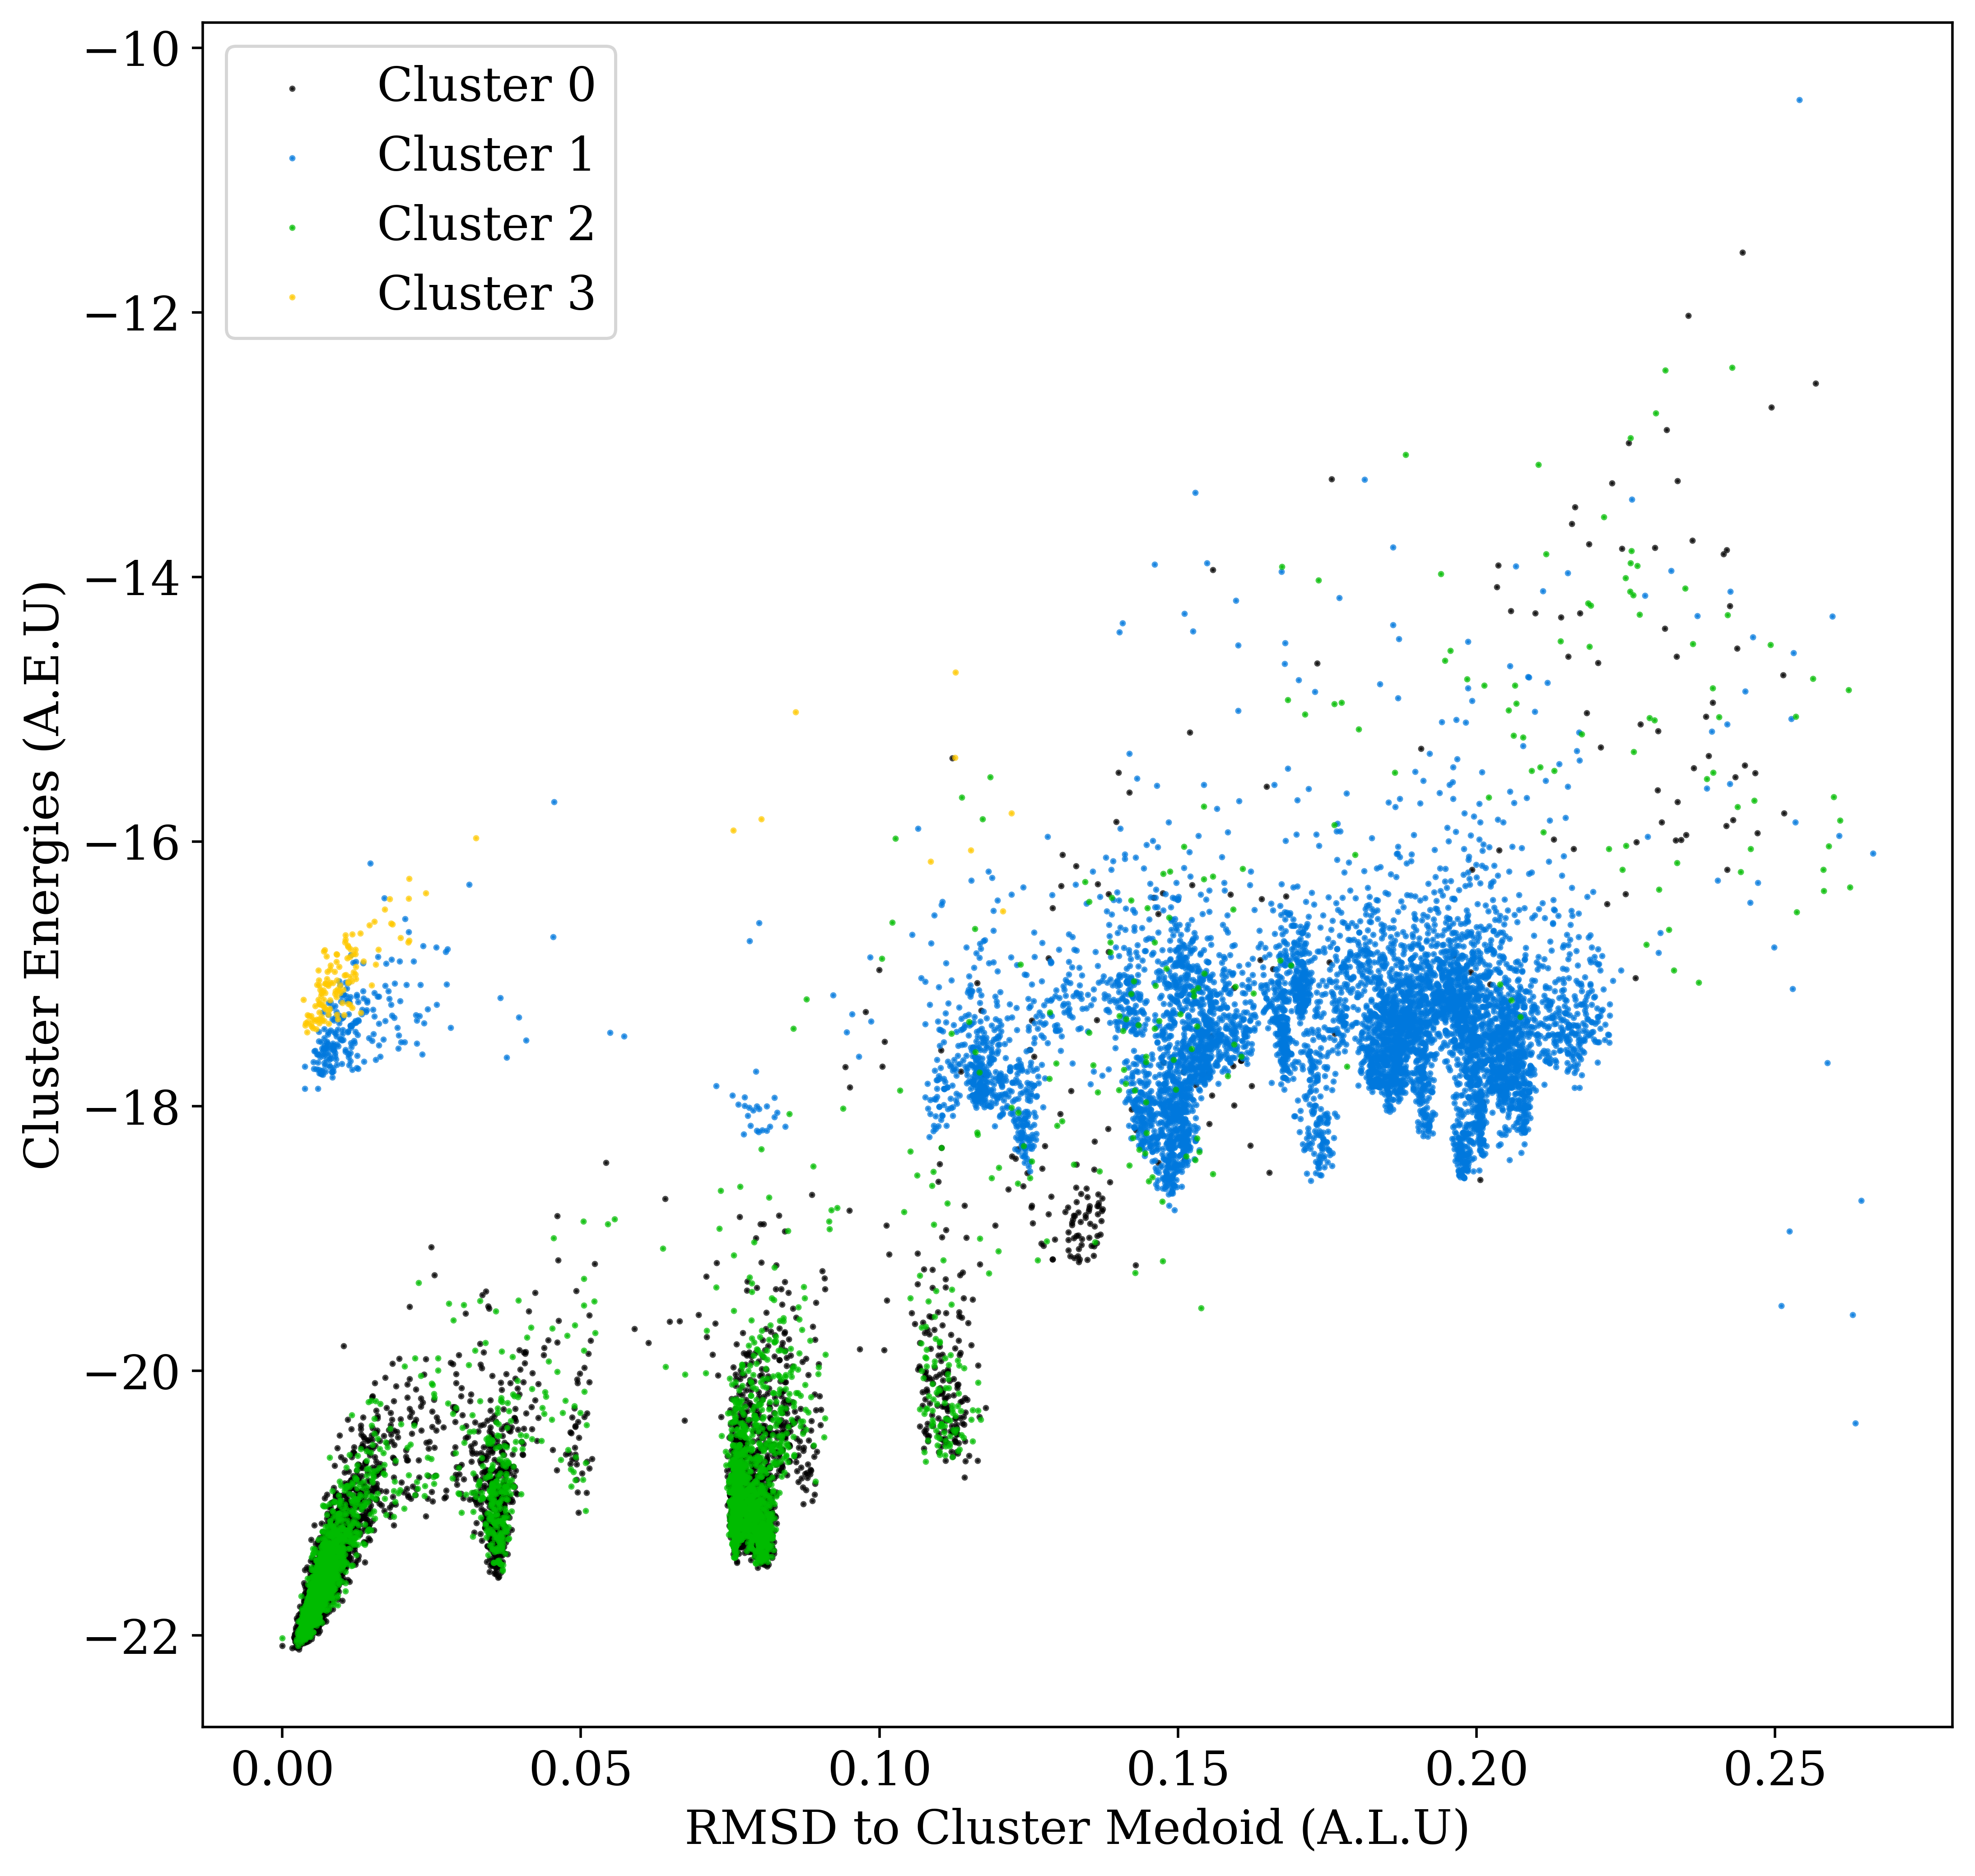

In [48]:
plt.figure(figsize = [10, 10], dpi=500)
clusters = np.unique(labels)
energy_stdevs = []
colors = ["k", "r", "b", "c"]
for i in clusters[1:]:
    medoid_mdtraj = md.load("cluster_output/medoid_" + str(i) + ".pdb")
    cluster_indices = np.where(labels == i)[0]
    rmsds_medoid_i = md.rmsd(all_traj[original_indices[cluster_indices]], medoid_mdtraj)
    cluster_energies = all_energies[original_indices[cluster_indices]]
    color = cm.nipy_spectral(float(i) / len(clusters[1:]))
    plt.scatter(rmsds_medoid_i, cluster_energies, s=1, alpha=0.7, c=color)
    plt.xlabel("RMSD to Cluster Medoid (A.L.U)")
    plt.ylabel("Cluster Energies (A.E.U)")
plt.legend(["Cluster "+ str(a) for a in clusters[1:]], loc = "best")

In [21]:
energy_stdevs

[]

In [20]:
cluster_rmsd

array([0.05154844, 0.04623311, 0.17307293, 0.00739772])

In [ ]:
# Distribution of minimum energy structures
sorted_energies = copy.deepcopy(all_energies)
sorted_energies.sort()
plt.hist(sorted_energies[:5000], bins=30)

In [22]:
all_traj = md.load(traj_file_list)

In [23]:
cluster_indices

array([11410, 11411, 11412, 11413, 11414, 11415, 11416, 11417, 11418,
       11419, 11420, 11421, 11422, 11423, 11424, 11425, 11426, 11427,
       11428, 11429, 11430, 11431, 11432, 11433, 11434, 11435, 11436,
       11437, 11438, 11439, 11440, 11441, 11442, 11443, 11444, 11445,
       11446, 11447, 11448, 11449, 11450, 11451, 11452, 11453, 11454,
       11455, 11456, 11457, 11458, 11459, 11460, 11461, 11462, 11463,
       11464, 11465, 11466, 11467, 11468, 11469, 11470, 11471, 11472,
       11473, 11474, 11475, 11476, 11477, 11478, 11479, 11480, 11481,
       11482, 11483, 11484, 11485, 11486, 11487, 11488, 11489, 11490,
       11491, 11492, 11493, 11494, 11495, 11496, 11497, 11498, 11499,
       11500, 11501, 11502, 11503, 11504, 11505, 11506, 11507, 11508,
       11509, 11510, 11511, 11512, 11513, 11514, 11515, 11516, 11517,
       11518, 11519, 11520, 11521, 11522, 11523, 11524, 11525, 11526,
       11527, 11528, 11529, 11530, 11531, 11532, 11533, 11534, 11535,
       11536, 11537]

In [41]:
traj = md.load(job.fn("trajectory.pdb"))
traj = traj.join(md.load(job.fn("trajectory.pdb")))
traj

<mdtraj.Trajectory with 2000 frames, 30 atoms, 5 residues, without unitcells at 0x7fc530f1afd0>

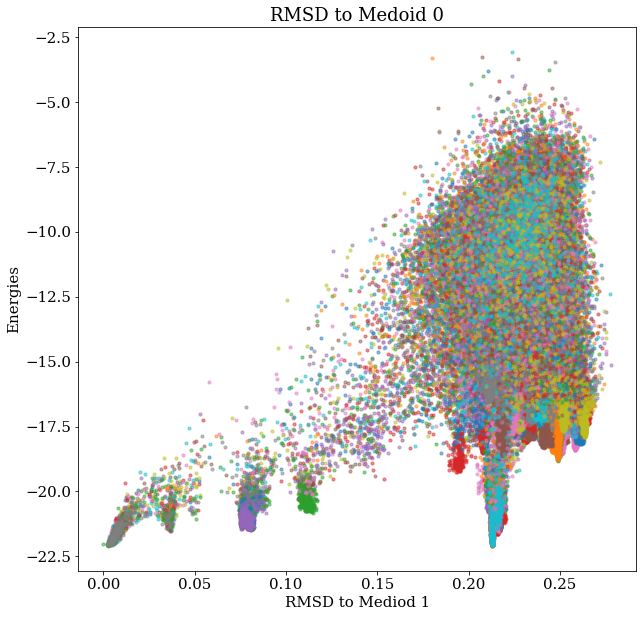

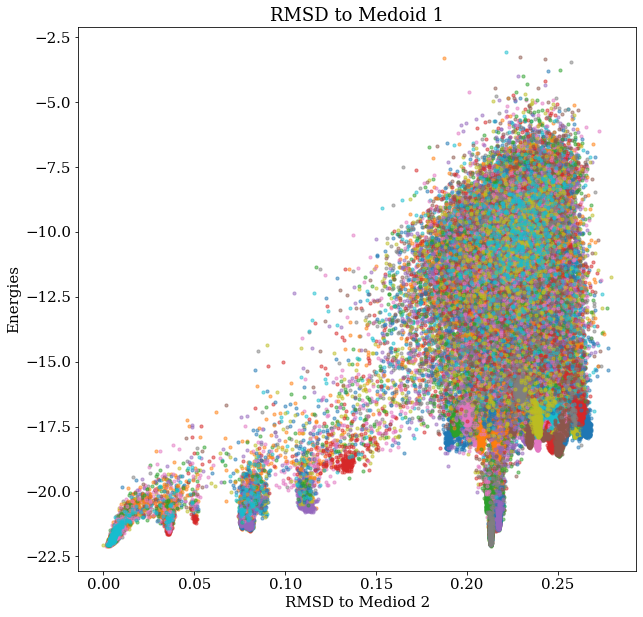

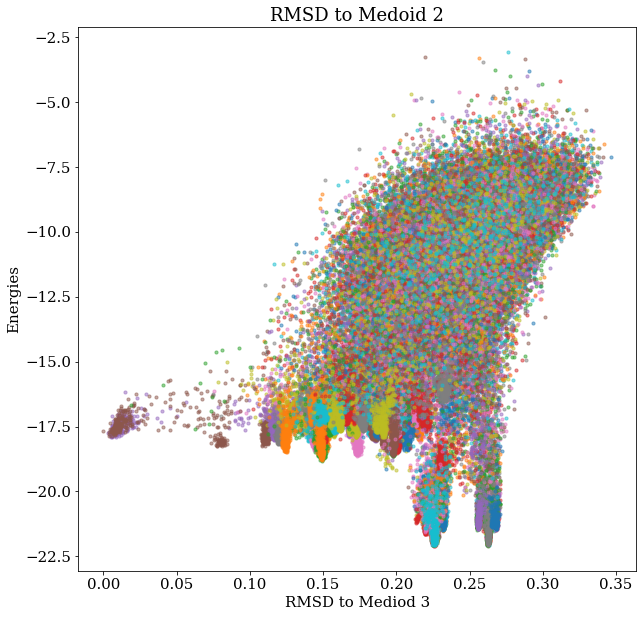

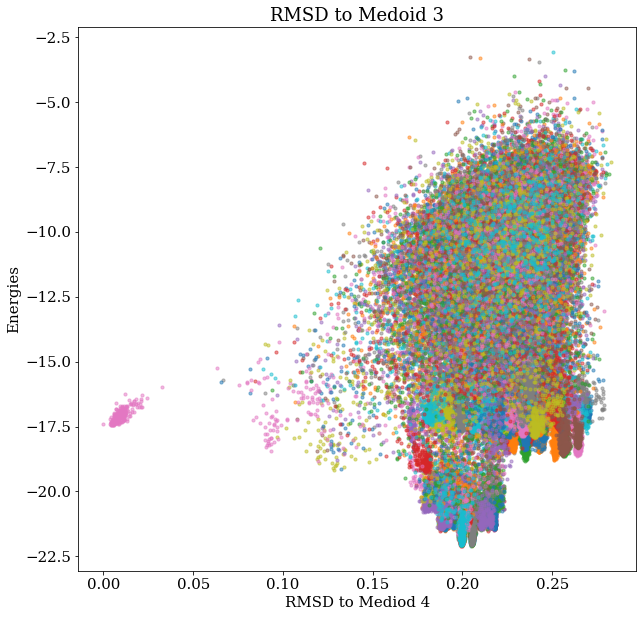

In [25]:
for i in clusters[1:]:
    plt.figure(figsize = [10,10])
    for j in range(len(sim_traj)):
        cluster_indices = np.where(labels == i)[0]
        medoid_mdtraj = md.load("cluster_output/medoid_" + str(i) + ".pdb")
        rmsds_medoid_i = md.rmsd(sim_traj[j], medoid_mdtraj)
        plt.scatter(rmsds_medoid_i, energy_traj[j], s = 10, alpha = 0.5)
        plt.xlabel("RMSD to Mediod " + str(i+1))
        plt.ylabel("Energies")
        plt.title("RMSD to Medoid " + str(i))
    plt.savefig(job.fn("kmedoid_rmsd_energy_scatter.jpg"), dpi=600)
    

In [26]:
# RMSD (to minimum energy structure) vs Energy

for sc_size in sc_sizes:
    plt.figure(figsize = [20,10])
    all_traj = md.load(traj_file_list)

    for job in project.find_jobs({'sc_size':sc_size}):
        # Get MC traj
        structure_file = job.fn("structure.txt")
        struct_loc = pd.read_csv(structure_file, header=None)
        traj = md.load([job.fn(file) for file in struct_loc[1].values])

        # Get minimum energy structure
        energy_file = job.fn("energies.txt")
        energies = pd.read_csv(energy_file, header=None).values[:,1]
        
        min_energy_index = np.where(all_energies == np.min(all_energies))
        min_energy_struct = all_traj.slice(min_energy_index)

        # Compute RMSDs to trajectory
        rmsds_medoid_i = md.rmsd(traj, min_energy_struct)

        plt.scatter(rmsds_medoid_i, energies, s = 1)
        
        
        
    # Get ALL MC traj
    structure_file = job.fn("structure.txt")
    struct_loc = pd.read_csv(structure_file, header=None)
    traj = md.load(traj_file_list)

    # Get minimum energy structure
    min_energy_index= np.where(all_energies == np.min(all_energies))
    min_energy_struct = traj.slice(min_energy_index)

    # Compute RMSDs to trajectory
    rmsds_medoid_i = md.rmsd(traj, min_energy_struct)
    
    # plt.figure(figsize = [20,10])
    # plt.scatter(rmsds_medoid_i, all_energies, s = 1)

        
    # Minimum energy structure
    
    minimum_index = min_energy_index[0][0]
    poi_1 = np.where(all_energies == sorted_energies[450])[0][0]
    poi_2 = np.where(all_energies == sorted_energies[471])[0][0]
    poi_3 = np.where(all_energies == sorted_energies[1400])[0][0]
    poi_4 = np.where(all_energies == sorted_energies[2300])[0][0]
    poi_5 = np.where(all_energies == sorted_energies[700])[0][0]
    
    min_energy_struct.save_pdb("overall_minimim.pdb")
    plt.scatter(rmsds_medoid_i[minimum_index], all_energies[minimum_index], c = 'r', s = 150, marker = 'D')
    plt.scatter(rmsds_medoid_i[poi_1], all_energies[poi_1], c = 'g', s = 150, marker = 'D')
    plt.scatter(rmsds_medoid_i[poi_2], all_energies[poi_2], c = 'y', s = 150, marker = 'D')
    plt.scatter(rmsds_medoid_i[poi_3], all_energies[poi_3], c = 'k', s = 150, marker = 'D')
    plt.scatter(rmsds_medoid_i[poi_4], all_energies[poi_4], c = 'm', s = 150, marker = 'D')
    plt.scatter(rmsds_medoid_i[poi_5], all_energies[poi_5], c = 'C1', s = 150, marker = 'D')
    legend_list = ["rep " + str(i) for i in range(10)]
    legend_list.extend(["Structure A", "Structure B", "Structure C", "Structure D", "Structure E", "Structure F"])
    plt.legend(legend_list)
    plt.xlabel("RMSD to Minimum Energy Structure")
    plt.ylabel("Energies")
    plt.savefig("min_energy_rmsd_energy_scatter.jpg", dpi=600)



OSError: Sorry, no loader for filename=/mnt/bridges/sc_size_experiment/workspace/14508b00a45b351cac40c54ccaea7fdc/Frame (extension=) was found. I can only load files with extensions in dict_keys(['.arc', '.dcd', '.binpos', '.xtc', '.trr', '.hdf5', '.h5', '.ncdf', '.netcdf', '.nc', '.pdb.gz', '.pdb', '.lh5', '.crd', '.mdcrd', '.inpcrd', '.restrt', '.rst7', '.ncrst', '.lammpstrj', '.dtr', '.stk', '.gro', '.xyz.gz', '.xyz', '.tng', '.xml', '.mol2', '.hoomdxml', '.gsd'])

<Figure size 1440x720 with 0 Axes>

In [ ]:
# Minimum energy structure

minimum_index = min_energy_index[0][0]
poi_1 = np.where(all_energies == sorted_energies[450])[0][0]
poi_2 = np.where(all_energies == sorted_energies[471])[0][0]
poi_3 = np.where(all_energies == sorted_energies[1400])[0][0]
poi_4 = np.where(all_energies == sorted_energies[2300])[0][0]
poi_5 = np.where(all_energies == sorted_energies[700])[0][0]

print("Minimum energy structure location:", traj_file_list[minimum_index])
print("Point of Interest 1 location:", traj_file_list[poi_1])
print("Point of Interest 2 location:", traj_file_list[poi_2])
print("Point of Interest 3 location:", traj_file_list[poi_3])
print("Point of Interest 4 location:", traj_file_list[poi_4])
print("Point of Interest 5 location:", traj_file_list[poi_5])



min_energy_struct.save_pdb("overall_minimim.pdb")
plt.figure(figsize = [20,10])
plt.scatter(rmsds_medoid_i, all_energies, s = 10, label = None)
plt.scatter(rmsds_medoid_i[minimum_index], all_energies[minimum_index], c = 'r', s = 150, marker = 'D')
plt.scatter(rmsds_medoid_i[poi_1], all_energies[poi_1], c = 'g', s = 150, marker = 'D')
plt.scatter(rmsds_medoid_i[poi_2], all_energies[poi_2], c = 'y', s = 150, marker = 'D')
plt.scatter(rmsds_medoid_i[poi_3], all_energies[poi_3], c = 'k', s = 150, marker = 'D')
plt.scatter(rmsds_medoid_i[poi_4], all_energies[poi_4], c = 'm', s = 150, marker = 'D')
plt.scatter(rmsds_medoid_i[poi_5], all_energies[poi_5], c = 'C1', s = 150, marker = 'D')
plt.legend(["All structures", "Structure A", "Structure B", "Structure C", "Structure D", "Structure E", "Structure F"])
plt.xlabel("RMSD to Minimum Energy Structure")
plt.ylabel("Energy (A.E.U)")
plt.savefig("min_energy_rmsd_energy_scatter.jpg", dpi=600)

In [ ]:
rmsd_matrix = np.zeros([traj.n_frames, traj.n_frames])
for i in range(traj.n_frames):
    rmsd_matrix[:, i] = md.rmsd(traj, traj.slice(i))

In [ ]:
plt.hist(rmsd_matrix.flatten(), bins = 100)
plt.ylabel("Count")
plt.xlabel("RMSDs")